In [1]:
from coldquanta.qiskit_tools.coldquanta_sim_backend import ColdQuantaSimBackend
from networkx import Graph, draw_planar
import numpy as np
from classical_optimization.qaoa_circuits import maxcut_qaoa_circuit
from qiskit import Aer, execute
from classical_optimization.qaoa_circuits import estimate_cost
from classical_optimization.qaoa_circuits import plot_landscape
%load_ext autoreload
%autoreload 2
%pdb

/Users/anthonypolloreno/.pyenv/versions/3.7.4/envs/qaoa_venv/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Automatic pdb calling has been turned ON


In [2]:
def the_whole_schebang(rows, cols):
    neutral_atom = ColdQuantaSimBackend(rows=rows, cols=cols)
    neutral_atom_config = neutral_atom.configuration()
    coupling_map = neutral_atom_config.coupling_map
    g = Graph(coupling_map)
    #draw_planar(g)
    #np.random.seed(137)
    weights = set()
    for k in coupling_map:
        weights.add((min(k), max(k)))
    # Fix the weights to 1, for now.
    weights = {k: 1  for k in weights}

    def produce_gammas_betas(discretization, max_gamma, max_beta):
        return np.linspace(0, max_gamma, discretization), np.linspace(0, max_beta, discretization)

    discretization = 20
    max_gamma = max_beta = np.pi
    gammas, betas = produce_gammas_betas(discretization, max_gamma, max_beta)

    simulator = Aer.get_backend('qasm_simulator')
    num_shots = 1024
    experiments = []
    for gamma in gammas:
        for beta in betas:
            experiments.append(maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights))
    job = execute(experiments, backend=simulator, shots=num_shots)    
    all_counts = job.result().get_counts()    
    landscape = np.zeros((discretization, discretization))
    for i, gamma in enumerate(gammas):
        for j, beta in enumerate(betas):
            landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)
    return landscape, max_gamma, max_beta, betas, gammas

In [3]:
optimal_pairs = []

In [4]:
import scipy.ndimage.filters as filters
neighborhood_size = 10
threshold = 0

def find_maxima(landscape):
    data = landscape
    data_max = filters.maximum_filter(data, (neighborhood_size, neighborhood_size))
    maxima = (data == data_max)
    data_min = filters.minimum_filter(data, (neighborhood_size, neighborhood_size))
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0
    maxima[0,:] = 0
    maxima[-1,:] = 0
    maxima[:,0] = 0
    maxima[:,-1] = 0
    # A[x,y] != A[x][y]
    # This is removing local maxima on the boundary (which at least don't exist on these regular graphs.)
    return np.where(maxima)

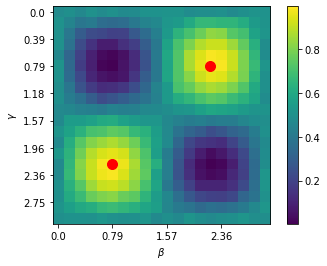

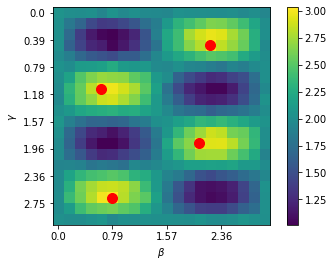

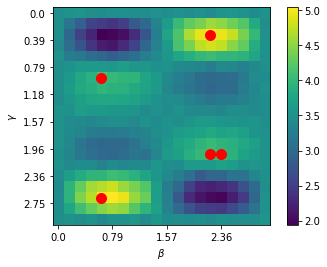

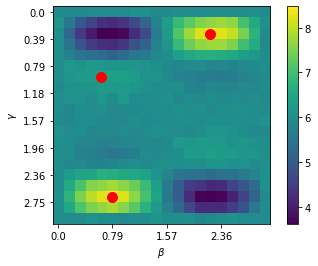

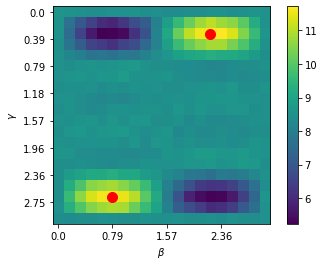

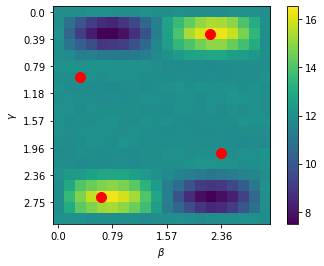

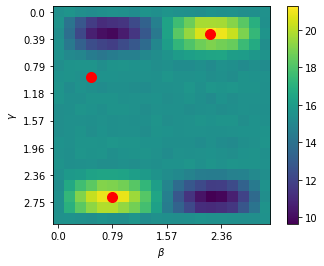

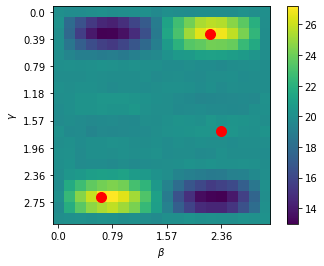

In [5]:
import matplotlib.pyplot as plt
import pickle
import time

optimal_pairs = {}
for rows,cols in [(2,1), (2,2), (3,2), (3,3), (4,3), (4,4), (5,4), (5,5)]:
    start = time.time()
    landscape, max_gamma, max_beta, betas, gammas = the_whole_schebang(rows, cols)
    stop = time.time()
    plot_landscape(landscape, max_gamma, max_beta)
    maxima = find_maxima(landscape)
    plt.scatter(maxima[1], maxima[0], c='r',s=100)
    
    pairs = list(zip(betas[maxima[0]], gammas[maxima[1]]))
    optimal_pairs[(rows,cols, len(betas)*len(gammas))] = (pairs, stop-start)
    plt.show()


with open('runtimes.pkl','rb') as handle:
    existing = pickle.load(handle)
with open('runtimes.pkl','wb') as handle:
    for k,v in optimal_pairs.items():
        new = {}
        pairs, times = existing.get(k, [[],[]])
        pairs.append(v[0])
        times.append(v[1])
        new[k] = [pairs, times]
    pickle.dump(new, handle)

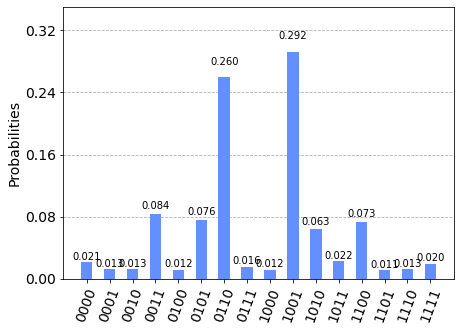

In [12]:
from qiskit.visualization import plot_histogram

plot_histogram(all_counts[np.argmax(landscape)])

# Now introduce noise!

In [13]:
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model

In [14]:
noise_model = create_noise_model()

In [15]:
noise_model = create_noise_model(cz_fidelity=0.7)

experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights))
job = execute(experiments,
              simulator,
              noise_model=noise_model,
              coupling_map=coupling_map,
              optimization_level=0,
              shots=num_shots)  
all_counts = job.result().get_counts()

In [16]:
noisy_landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        noisy_landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

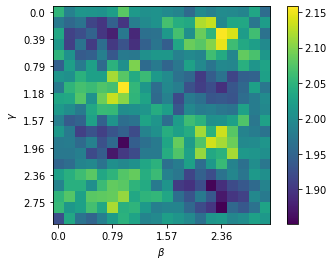

In [17]:
plot_landscape(noisy_landscape, max_gamma, max_beta);

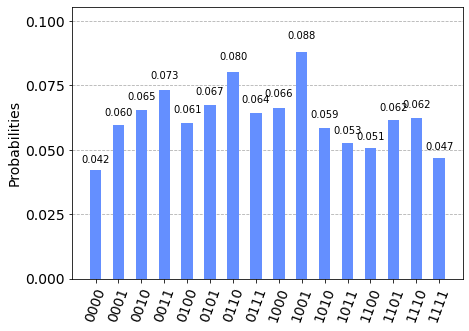

In [18]:
plot_histogram(all_counts[np.argmax(noisy_landscape)])

# Include Classical Optimizer

In [19]:
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
simulator = Aer.get_backend('qasm_simulator')
shots_per_point = 1000

$\gamma$,$\beta$=[2.75429392 0.79267797]
Max cut is 2.966


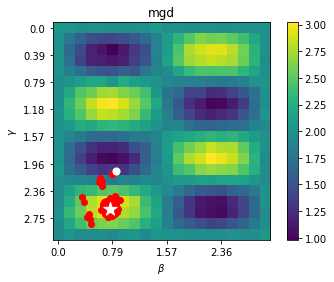

In [37]:
from classical_optimization.qaoa_circuits import try_optimizer
import matplotlib.pyplot as plt
noise_model = create_noise_model(cz_fidelity=0.7)
noise_model = None

for method in ['mgd']:#['nelder-mead', 'powell', 'mgd']:
    history = []
    result = try_optimizer(method, simulator, neutral_atom_config.coupling_map, shots_per_point,
                           weights, max_gamma, max_beta, rows, cols, history, noise_model)
    history.append(result.x) #We will append the last visited point, since the plotting assumes this is the optimal value.
    plot_landscape(landscape, max_gamma, max_beta, history=history, discretization=discretization)
    plt.title(method)
    plt.show()

## Larger Depths!

In [31]:
discretization = 8
max_gamma = max_beta = np.pi
gammas, betas = produce_gammas_betas(discretization, max_gamma, max_beta)

In [33]:
import tqdm as tqdm
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
experiments = []
for gamma in gammas:
    for beta in betas:
        for gamma1 in gammas:
            for beta1 in betas:
                experiments.append(maxcut_qaoa_circuit(gammas=[gamma, gamma1], betas=[beta, beta1], p=2, rows=rows, cols=cols, weights=weights))
job = execute(experiments, backend=simulator, shots=num_shots)    
all_counts = job.result().get_counts()

In [34]:
landscape = np.zeros((discretization, discretization, discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        for k, gamma in enumerate(gammas):
            for l, beta in enumerate(betas):
                landscape[i][j][k][l] = estimate_cost(all_counts[i*len(betas)*len(gammas)*len(betas)+j*len(betas)*len(gammas)+k*len(betas) + l], weights)

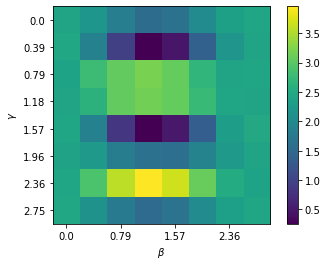

In [35]:
plot_landscape(landscape[np.unravel_index(landscape.argmax(), landscape.shape)[0:2]], max_gamma, max_beta, colorbar=True)

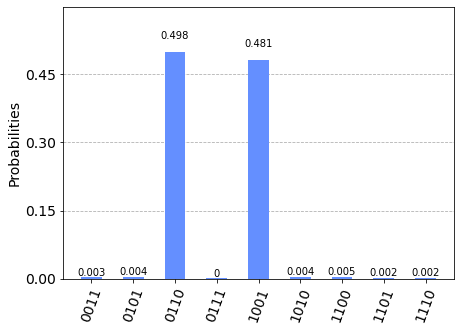

In [36]:
plot_histogram(all_counts[landscape.argmax()])

# With noise!

In [37]:
import tqdm as tqdm
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
experiments = []
for gamma in gammas:
    for beta in betas:
        for gamma1 in gammas:
            for beta1 in betas:
                experiments.append(maxcut_qaoa_circuit(gammas=[gamma, gamma1], betas=[beta, beta1], p=2, rows=rows, cols=cols, weights=weights))
job = execute(experiments, backend=simulator, shots=num_shots, noise_model=noise_model)    
all_counts = job.result().get_counts()

In [38]:
noisy_landscape = np.zeros((discretization, discretization, discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        for k, gamma in enumerate(gammas):
            for l, beta in enumerate(betas):
                noisy_landscape[i][j][k][l] = estimate_cost(all_counts[i*len(betas)*len(gammas)*len(betas)+j*len(betas)*len(gammas)+k*len(betas) + l], weights)

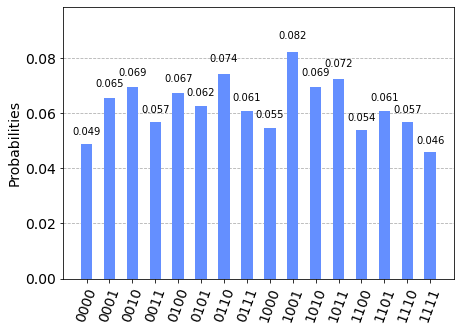

In [39]:
plot_histogram(all_counts[noisy_landscape.argmax()])

In [40]:
# I wonder if there are optimization techniques that helped by knowledge of the noise.